In [3]:
#import statements
import os
import numpy as np
import tensorflow as tf
import cv2
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model


In [4]:
# two arrays to store the testing loss and testing accuracy after on each video for 10 epochs
tl=[]
ac=[]

data preprocessing

In [5]:
# Data preprocessing for all input images
def detect_black_border(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)[1]
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = sorted(contours, key=cv2.contourArea, reverse=True)[0]
    x, y, w, h = cv2.boundingRect(largest_contour)
    shrink_factor = 0.05
    x += int(w * shrink_factor)
    y += int(h * shrink_factor)
    w = int(w * (1 - 2 * shrink_factor))
    h = int(h * (1 - 2 * shrink_factor))
    return x, y, w, h

def img_preprocess(img_path,x1,y1,w,h):
    def crop_and_resize(image, x, y, w, h, target_size=(224, 224)):
        bbox = (x, y, x + w, y + h)
        cropped_image = Image.fromarray(image).crop(bbox)
        resized_image = cropped_image.resize(target_size, Image.BILINEAR)
        return np.array(resized_image)

    def process_image(image_path, target_size=(224, 224)):
        image = cv2.imread(image_path)
        if x1 >= 0 and y1 >= 0 and w > 0 and h > 0:
            cropped_resized_image = crop_and_resize(image.copy(), x1, y1, w, h, target_size)
            return cropped_resized_image
        else:
            return image.resize(target_size, Image.BILINEAR)
    
    return process_image(img_path)

def return_x_y(video):
    data_dir = "/kaggle/input/ps2-lc-pure/PS2Train"
    video_folders = os.listdir(data_dir)
    X, y = [], []
    sample_folders=os.listdir(os.path.join(data_dir, video))
    images=os.listdir(os.path.join(data_dir, video,sample_folders[0]))
    image_path = os.path.join(data_dir, video, sample_folders[0], images[0])
    image_temp = cv2.imread(image_path)
    x1,y1,w,h=detect_black_border(image_temp)

    for sample_folder in os.listdir(os.path.join(data_dir, video)):
        label = int(sample_folder[-1]) 
        image_paths = os.listdir(os.path.join(data_dir, video, sample_folder))
       
        # Load and preprocess images
        temp=[]
        for img_path in image_paths:
            new_img= img_preprocess(os.path.join(data_dir,video,sample_folder,img_path),x1,y1,w,h)
            temp.append(new_img)
        X.append(temp)
        y.append(label)

    X = np.array(X)
    y = np.array(y)
    return X,y

model architecture

In [6]:
# pixel based cnn architecture making use of the 3 convolution 3D layers

from tensorflow import keras
inputs = keras.Input(shape=(10, 224, 224, 3)) 
x = inputs

for _ in range(3):
  x = layers.Conv3D(64, (3, 3, 3), padding="same", use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2))(x)

# Flatten before classification
x = layers.Flatten()(x)

# Dense layers for classification
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x) 

# defining the new model
model = keras.Model(inputs=inputs, outputs=outputs)


# Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])




In [ ]:
model=load_model("/kaggle/input/model-prefinal/backup-final.h5")
model.summary()

In [6]:
# early stopping and reducing learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

perform training for each of the 48 videos (80% of the dataset). Avoided using a for loop for training the model accross all the videos as this gave multiple resource exhaustive errors(CPU and RAM)

In [16]:
X,y=return_x_y('video01')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10


W0000 00:00:1712980642.693949      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5623 - loss: 76.4732 - val_accuracy: 0.4545 - val_loss: 242.9984 - learning_rate: 0.0010
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 718ms/step - accuracy: 0.7254 - loss: 11.3530 - val_accuracy: 0.2727 - val_loss: 235.8211 - learning_rate: 0.0010
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 721ms/step - accuracy: 0.7631 - loss: 10.5842 - val_accuracy: 0.1818 - val_loss: 532.8569 - learning_rate: 0.0010
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 716ms/step - accuracy: 0.7249 - loss: 5.8843 - val_accuracy: 0.2727 - val_loss: 286.8824 - learning_rate: 0.0010
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 706ms/step - accuracy: 0.7705 - loss: 5.8939 - val_accuracy: 0.3636 - val_loss: 165.0181 - learning_rate: 1.0000e-04
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 695ms/step - accuracy: 0.8478 - loss: 3.7460 - val_accuracy: 0.4545 - val_loss: 67.7448 - learning_rate: 1.0000e-04
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 690ms/step - accuracy: 0.9038 - loss: 3.7247 - val_a

In [36]:
tl.append(40.64625)
ac.append(0.69230)

In [19]:
X,y=return_x_y('video05')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8933 - loss: 1.8170 - val_accuracy: 0.7778 - val_loss: 12.6859 - learning_rate: 1.0000e-05
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 802ms/step - accuracy: 0.8968 - loss: 2.0297 - val_accuracy: 0.7778 - val_loss: 11.8507 - learning_rate: 1.0000e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 816ms/step - accuracy: 0.9003 - loss: 1.3145 - val_accuracy: 0.7778 - val_loss: 11.1514 - learning_rate: 1.0000e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9000 - loss: 3.4276
Test Loss: 3.4276459217071533
Test Accuracy: 0.8999999761581421


In [37]:
tl.append(3.427645)
ac.append(0.899999)

In [20]:
X,y=return_x_y('video50')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.6876 - loss: 25.1091 - val_accuracy: 0.0000e+00 - val_loss: 52.9882 - learning_rate: 1.0000e-05
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step - accuracy: 0.7272 - loss: 23.2562 - val_accuracy: 0.0000e+00 - val_loss: 50.2822 - learning_rate: 1.0000e-05
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 642ms/step - accuracy: 0.6376 - loss: 29.0591 - val_accuracy: 0.0000e+00 - val_loss: 47.6816 - learning_rate: 1.0000e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.5714 - loss: 20.3827
Test Loss: 20.382715225219727
Test Accuracy: 0.5714285969734192


In [38]:
tl.append(20.38271)
ac.append(0.571428)

In [21]:
X,y=return_x_y('video07')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 831ms/step - accuracy: 0.7769 - loss: 16.3643 - val_accuracy: 0.5556 - val_loss: 29.7993 - learning_rate: 1.0000e-05
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 831ms/step - accuracy: 0.8575 - loss: 9.1262 - val_accuracy: 0.5556 - val_loss: 28.1658 - learning_rate: 1.0000e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 847ms/step - accuracy: 0.8444 - loss: 6.7052 - val_accuracy: 0.5556 - val_loss: 26.7345 - learning_rate: 1.0000e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7000 - loss: 16.4154
Test Loss: 16.41541862487793
Test Accuracy: 0.699999988079071


In [39]:
tl.append(16.41541)
ac.append(0.699999)

In [22]:
X,y=return_x_y('video30')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9292 - loss: 2.3975 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 751ms/step - accuracy: 0.8938 - loss: 5.5557 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 758ms/step - accuracy: 0.9625 - loss: 2.2277 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8750 - loss: 20.9759
Test Loss: 20.97585678100586
Test Accuracy: 0.875


In [40]:
tl.append(20.97585)
ac.append(0.875)

In [23]:
X,y=return_x_y('video45')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6363 - loss: 14.4533 - val_accuracy: 0.5000 - val_loss: 26.0125 - learning_rate: 1.0000e-06
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step - accuracy: 0.6843 - loss: 15.5097 - val_accuracy: 0.5000 - val_loss: 25.4883 - learning_rate: 1.0000e-06
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step - accuracy: 0.6708 - loss: 18.0527 - val_accuracy: 0.5000 - val_loss: 25.0097 - learning_rate: 1.0000e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.2857 - loss: 38.5739
Test Loss: 38.57390594482422
Test Accuracy: 0.2857142984867096


In [41]:
tl.append(38.57390)
ac.append(0.285714)

In [24]:
X,y=return_x_y('video37')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 811ms/step - accuracy: 0.8318 - loss: 8.3052 - val_accuracy: 0.3333 - val_loss: 10.0918 - learning_rate: 1.0000e-06
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 782ms/step - accuracy: 0.8552 - loss: 6.8244 - val_accuracy: 0.3333 - val_loss: 9.6575 - learning_rate: 1.0000e-06
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 795ms/step - accuracy: 0.8943 - loss: 5.6429 - val_accuracy: 0.5000 - val_loss: 9.2664 - learning_rate: 1.0000e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 0.0347
Test Loss: 0.034698642790317535
Test Accuracy: 1.0


In [42]:
tl.append(0.034698)
ac.append(1.0000)

In [25]:
X,y=return_x_y('video23')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8564 - loss: 2.1513 - val_accuracy: 0.8571 - val_loss: 7.1078 - learning_rate: 1.0000e-06
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 678ms/step - accuracy: 0.8439 - loss: 3.2112 - val_accuracy: 0.8571 - val_loss: 7.0453 - learning_rate: 1.0000e-06
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 678ms/step - accuracy: 0.9053 - loss: 1.4111 - val_accuracy: 0.8571 - val_loss: 6.9780 - learning_rate: 1.0000e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8571 - loss: 1.0103
Test Loss: 1.0103063583374023
Test Accuracy: 0.8571428656578064


In [43]:
tl.append(1.010306)
ac.append(0.8571428)

In [26]:
X,y=return_x_y('video11')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 679ms/step - accuracy: 1.0000 - loss: 9.8923e-10 - val_accuracy: 0.8000 - val_loss: 9.7944 - learning_rate: 1.0000e-06
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 663ms/step - accuracy: 1.0000 - loss: 1.0182e-07 - val_accuracy: 0.8000 - val_loss: 9.5494 - learning_rate: 1.0000e-06
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 664ms/step - accuracy: 1.0000 - loss: 1.4773e-06 - val_accuracy: 0.8000 - val_loss: 9.2889 - learning_rate: 1.0000e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Test Loss: 0.0
Test Accuracy: 1.0


In [44]:
tl.append(0.0000)
ac.append(1.0000)

In [27]:
X,y=return_x_y('video31')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7415 - loss: 17.4836 - val_accuracy: 1.0000 - val_loss: 4.2486e-26 - learning_rate: 1.0000e-06
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step - accuracy: 0.7460 - loss: 14.0271 - val_accuracy: 1.0000 - val_loss: 1.4130e-24 - learning_rate: 1.0000e-06
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step - accuracy: 0.7787 - loss: 14.9245 - val_accuracy: 1.0000 - val_loss: 1.6790e-23 - learning_rate: 1.0000e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7143 - loss: 18.1473
Test Loss: 18.147336959838867
Test Accuracy: 0.7142857313156128


In [45]:
tl.append(18.14733)
ac.append(0.714285)

In [28]:
X,y=return_x_y('video47')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8826 - loss: 6.8535 - val_accuracy: 0.8571 - val_loss: 15.7364 - learning_rate: 1.0000e-07
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 808ms/step - accuracy: 0.9371 - loss: 1.6722 - val_accuracy: 0.8571 - val_loss: 15.4744 - learning_rate: 1.0000e-07
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 812ms/step - accuracy: 0.9476 - loss: 4.0330 - val_accuracy: 0.8571 - val_loss: 15.2320 - learning_rate: 1.0000e-07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 3.4384e-19
Test Loss: 3.4384238532725426e-19
Test Accuracy: 1.0


In [46]:
tl.append(0.00000)
ac.append(1.00000)

In [29]:
X,y=return_x_y('video06')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8782 - loss: 4.0877 - val_accuracy: 1.0000 - val_loss: 5.9754e-10 - learning_rate: 1.0000e-07
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step - accuracy: 0.9276 - loss: 2.9639 - val_accuracy: 1.0000 - val_loss: 3.7663e-10 - learning_rate: 1.0000e-07
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step - accuracy: 0.8782 - loss: 4.8760 - val_accuracy: 1.0000 - val_loss: 2.4647e-10 - learning_rate: 1.0000e-07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7143 - loss: 53.6614
Test Loss: 53.661441802978516
Test Accuracy: 0.7142857313156128


In [47]:
tl.append(53.66144)
ac.append(0.714286)

In [30]:
X,y=return_x_y('video49')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 818ms/step - accuracy: 0.9674 - loss: 0.3319 - val_accuracy: 0.6667 - val_loss: 3.1087 - learning_rate: 1.0000e-08
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 799ms/step - accuracy: 0.9470 - loss: 0.3786 - val_accuracy: 0.6667 - val_loss: 2.7050 - learning_rate: 1.0000e-08
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 797ms/step - accuracy: 0.9596 - loss: 0.5616 - val_accuracy: 0.6667 - val_loss: 2.3240 - learning_rate: 1.0000e-08
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Test Loss: 0.0
Test Accuracy: 1.0


In [48]:
tl.append(0.00000)
ac.append(1.00000)

In [31]:
X,y=return_x_y('video12')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step - accuracy: 0.9524 - loss: 0.4851 - val_accuracy: 0.6667 - val_loss: 4.0290 - learning_rate: 1.0000e-08
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step - accuracy: 0.9274 - loss: 0.7089 - val_accuracy: 0.6667 - val_loss: 3.9512 - learning_rate: 1.0000e-08
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step - accuracy: 0.9695 - loss: 0.6597 - val_accuracy: 0.6667 - val_loss: 3.8842 - learning_rate: 1.0000e-08
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 2.9699e-36
Test Loss: 2.969893042155555e-36
Test Accuracy: 1.0


In [49]:
tl.append(0.0000)
ac.append(1.0000)

In [32]:
X,y=return_x_y('video29')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9598 - loss: 1.0363 - val_accuracy: 0.5714 - val_loss: 15.2511 - learning_rate: 1.0000e-08
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 700ms/step - accuracy: 0.9027 - loss: 4.0278 - val_accuracy: 0.5714 - val_loss: 14.4903 - learning_rate: 1.0000e-08
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 706ms/step - accuracy: 0.9557 - loss: 1.5667 - val_accuracy: 0.5714 - val_loss: 13.6740 - learning_rate: 1.0000e-08
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 5.5814e-41
Test Loss: 0.0
Test Accuracy: 1.0


In [50]:
tl.append(0.0000)
ac.append(1.0000)

In [33]:
X,y=return_x_y('video53')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step - accuracy: 0.7919 - loss: 9.7409 - val_accuracy: 0.8571 - val_loss: 13.0079 - learning_rate: 1.0000e-08
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 672ms/step - accuracy: 0.7971 - loss: 9.5949 - val_accuracy: 0.8571 - val_loss: 13.2131 - learning_rate: 1.0000e-08
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 674ms/step - accuracy: 0.7971 - loss: 11.2809 - val_accuracy: 0.8571 - val_loss: 13.4101 - learning_rate: 1.0000e-08
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8571 - loss: 10.0803
Test Loss: 10.080281257629395
Test Accuracy: 0.8571428656578064


In [51]:
tl.append(10.08028)
ac.append(0.857142)

In [34]:
X,y=return_x_y('video13')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7898 - loss: 5.0729 - val_accuracy: 0.4000 - val_loss: 23.6045 - learning_rate: 1.0000e-09
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 730ms/step - accuracy: 0.7391 - loss: 5.7149 - val_accuracy: 0.4000 - val_loss: 23.0085 - learning_rate: 1.0000e-09
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 728ms/step - accuracy: 0.7860 - loss: 5.7197 - val_accuracy: 0.4000 - val_loss: 22.4037 - learning_rate: 1.0000e-09
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.1667 - loss: 33.9287
Test Loss: 33.92870330810547
Test Accuracy: 0.1666666716337204


In [52]:
tl.append(33.92870)
ac.append(0.166666)

In [35]:
X,y=return_x_y('video40')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 834ms/step - accuracy: 0.8879 - loss: 3.3636 - val_accuracy: 0.8333 - val_loss: 3.6453 - learning_rate: 1.0000e-09
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 810ms/step - accuracy: 0.8332 - loss: 5.2613 - val_accuracy: 0.8333 - val_loss: 3.3865 - learning_rate: 1.0000e-09
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 817ms/step - accuracy: 0.8488 - loss: 5.2742 - val_accuracy: 0.8333 - val_loss: 3.1315 - learning_rate: 1.0000e-09
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6667 - loss: 4.6650
Test Loss: 4.6649603843688965
Test Accuracy: 0.6666666865348816


In [53]:
tl.append(4.66496)
ac.append(0.66666)

In [37]:
model.save("backup.h5")

In [38]:
X,y=return_x_y('video17')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 859ms/step - accuracy: 0.8999 - loss: 4.1854 - val_accuracy: 0.8333 - val_loss: 13.3886 - learning_rate: 1.0000e-09
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 834ms/step - accuracy: 0.9496 - loss: 2.4568 - val_accuracy: 0.8333 - val_loss: 12.9161 - learning_rate: 1.0000e-09
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 845ms/step - accuracy: 0.9312 - loss: 2.7875 - val_accuracy: 0.8333 - val_loss: 12.4686 - learning_rate: 1.0000e-09
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Test Loss: 0.0
Test Accuracy: 1.0


In [54]:
tl.append(0.0000)
ac.append(1.0000)

In [39]:
X,y=return_x_y('video27')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 597ms/step - accuracy: 0.8637 - loss: 3.6253 - val_accuracy: 0.8333 - val_loss: 2.0467 - learning_rate: 1.0000e-09
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 581ms/step - accuracy: 0.8324 - loss: 3.9127 - val_accuracy: 0.8333 - val_loss: 1.7492 - learning_rate: 1.0000e-09
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 577ms/step - accuracy: 0.8199 - loss: 5.8632 - val_accuracy: 0.8333 - val_loss: 1.4672 - learning_rate: 1.0000e-09
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 0.0681
Test Loss: 0.06808217614889145
Test Accuracy: 1.0


In [55]:
tl.append(0.06808)
ac.append(1.00000)

In [41]:
X,y=return_x_y('video04')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 774ms/step - accuracy: 0.9233 - loss: 2.3612 - val_accuracy: 1.0000 - val_loss: 3.8307e-36 - learning_rate: 1.0000e-10
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 765ms/step - accuracy: 0.9233 - loss: 2.7144 - val_accuracy: 1.0000 - val_loss: 1.6391e-35 - learning_rate: 1.0000e-10
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 770ms/step - accuracy: 0.9192 - loss: 2.4063 - val_accuracy: 1.0000 - val_loss: 7.4267e-35 - learning_rate: 1.0000e-10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 0.0256
Test Loss: 0.025632958859205246
Test Accuracy: 1.0


In [56]:
tl.append(0.025632)
ac.append(1.00000)

In [43]:
X,y=return_x_y('video14')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 663ms/step - accuracy: 0.8919 - loss: 2.5295 - val_accuracy: 0.8750 - val_loss: 0.9432 - learning_rate: 1.0000e-12
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step - accuracy: 0.9468 - loss: 1.8736 - val_accuracy: 0.8750 - val_loss: 0.8824 - learning_rate: 1.0000e-12
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 667ms/step - accuracy: 0.9228 - loss: 1.9600 - val_accuracy: 0.8750 - val_loss: 0.7733 - learning_rate: 1.0000e-12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 2.7719e-06
Test Loss: 2.771921117528109e-06
Test Accuracy: 1.0


In [57]:
tl.append(0.0000)
ac.append(1.0000)

In [44]:
X,y=return_x_y('video57')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 804ms/step - accuracy: 0.8072 - loss: 6.1578 - val_accuracy: 0.8571 - val_loss: 2.6467 - learning_rate: 1.0000e-12
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 799ms/step - accuracy: 0.8490 - loss: 7.5421 - val_accuracy: 0.8571 - val_loss: 2.6503 - learning_rate: 1.0000e-12
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 808ms/step - accuracy: 0.8281 - loss: 5.9965 - val_accuracy: 0.8571 - val_loss: 2.6508 - learning_rate: 1.0000e-12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 1.8031e-08
Test Loss: 1.80314536635251e-08
Test Accuracy: 1.0


In [58]:
tl.append(0.000)
ac.append(1.000)

In [45]:
X,y=return_x_y('video60')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step - accuracy: 0.8197 - loss: 7.8142 - val_accuracy: 0.8333 - val_loss: 7.5023 - learning_rate: 1.0000e-13
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step - accuracy: 0.8062 - loss: 8.4534 - val_accuracy: 0.8333 - val_loss: 7.5258 - learning_rate: 1.0000e-13
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 675ms/step - accuracy: 0.8625 - loss: 5.8191 - val_accuracy: 0.8333 - val_loss: 7.5004 - learning_rate: 1.0000e-13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7143 - loss: 23.3957
Test Loss: 23.395715713500977
Test Accuracy: 0.7142857313156128


In [59]:
tl.append(23.39571)
ac.append(0.714285)

In [46]:
X,y=return_x_y('video02')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 770ms/step - accuracy: 0.7777 - loss: 8.4588 - val_accuracy: 0.9167 - val_loss: 3.2087 - learning_rate: 1.0000e-13
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 728ms/step - accuracy: 0.7966 - loss: 6.4488 - val_accuracy: 0.9167 - val_loss: 3.0431 - learning_rate: 1.0000e-13
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 737ms/step - accuracy: 0.7268 - loss: 6.5762 - val_accuracy: 0.9167 - val_loss: 2.9149 - learning_rate: 1.0000e-13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.5385 - loss: 28.4257
Test Loss: 28.42565155029297
Test Accuracy: 0.5384615659713745


In [60]:
tl.append(28.42565)
ac.append(0.538461)

In [47]:
X,y=return_x_y('video08')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 684ms/step - accuracy: 0.9063 - loss: 6.1978 - val_accuracy: 0.5000 - val_loss: 12.9911 - learning_rate: 1.0000e-13
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step - accuracy: 0.8967 - loss: 5.7687 - val_accuracy: 0.5000 - val_loss: 12.8065 - learning_rate: 1.0000e-13
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 672ms/step - accuracy: 0.8768 - loss: 8.2096 - val_accuracy: 0.5000 - val_loss: 12.5786 - learning_rate: 1.0000e-13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7778 - loss: 4.5862
Test Loss: 4.586190700531006
Test Accuracy: 0.7777777910232544


In [61]:
tl.append(4.58619)
ac.append(0.77777)

In [48]:
X,y=return_x_y('video16')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 835ms/step - accuracy: 0.8620 - loss: 3.4694 - val_accuracy: 0.8333 - val_loss: 6.7352 - learning_rate: 1.0000e-13
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 828ms/step - accuracy: 0.9010 - loss: 2.2835 - val_accuracy: 0.8333 - val_loss: 6.7351 - learning_rate: 1.0000e-13
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 826ms/step - accuracy: 0.8568 - loss: 3.3972 - val_accuracy: 0.8333 - val_loss: 6.7348 - learning_rate: 1.0000e-13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 9.4675e-08
Test Loss: 9.467539996421692e-08
Test Accuracy: 1.0


In [62]:
tl.append(0.0000)
ac.append(1.0000)

In [52]:
X,y=return_x_y('video24')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 761ms/step - accuracy: 0.9416 - loss: 0.8616 - val_accuracy: 1.0000 - val_loss: 4.4954e-19 - learning_rate: 1.0000e-15
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 747ms/step - accuracy: 0.9656 - loss: 0.4686 - val_accuracy: 1.0000 - val_loss: 2.7287e-18 - learning_rate: 1.0000e-15
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 749ms/step - accuracy: 0.9588 - loss: 0.8358 - val_accuracy: 1.0000 - val_loss: 1.3897e-17 - learning_rate: 1.0000e-15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.9663e-10
Test Loss: 1.9662621530969204e-10
Test Accuracy: 1.0


In [63]:
tl.append(0.000)
ac.append(1.000)

In [53]:
X,y=return_x_y('video42')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8435 - loss: 5.4316 - val_accuracy: 0.3333 - val_loss: 17.8036 - learning_rate: 1.0000e-16
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step - accuracy: 0.9013 - loss: 2.1990 - val_accuracy: 0.3333 - val_loss: 16.0943 - learning_rate: 1.0000e-16
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step - accuracy: 0.8842 - loss: 3.6017 - val_accuracy: 0.5000 - val_loss: 14.7593 - learning_rate: 1.0000e-16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7143 - loss: 6.0171
Test Loss: 6.017109394073486
Test Accuracy: 0.7142857313156128


In [64]:
tl.append(6.017109)
ac.append(0.714285)

In [54]:
X,y=return_x_y('video44')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 763ms/step - accuracy: 0.8145 - loss: 7.6428 - val_accuracy: 0.8571 - val_loss: 10.9858 - learning_rate: 1.0000e-16
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 747ms/step - accuracy: 0.7718 - loss: 9.7519 - val_accuracy: 0.8571 - val_loss: 10.9728 - learning_rate: 1.0000e-16
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 746ms/step - accuracy: 0.7639 - loss: 7.7356 - val_accuracy: 0.8571 - val_loss: 10.9598 - learning_rate: 1.0000e-16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.6250 - loss: 21.4673
Test Loss: 21.467269897460938
Test Accuracy: 0.625


In [65]:
tl.append(21.46726)
ac.append(0.625000)

In [55]:
X,y=return_x_y('video51')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 577ms/step - accuracy: 0.8574 - loss: 6.8862 - val_accuracy: 1.0000 - val_loss: 0.0353 - learning_rate: 1.0000e-16
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 571ms/step - accuracy: 0.8243 - loss: 11.6573 - val_accuracy: 1.0000 - val_loss: 0.0267 - learning_rate: 1.0000e-16
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 566ms/step - accuracy: 0.8639 - loss: 5.7202 - val_accuracy: 1.0000 - val_loss: 0.0171 - learning_rate: 1.0000e-16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 0.0065
Test Loss: 0.006460762117058039
Test Accuracy: 1.0


In [66]:
tl.append(0.00646)
ac.append(1.00000)

In [56]:
X,y=return_x_y('video52')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step - accuracy: 0.8378 - loss: 6.9403 - val_accuracy: 0.8333 - val_loss: 5.9642 - learning_rate: 1.0000e-16
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step - accuracy: 0.7428 - loss: 10.5097 - val_accuracy: 0.8333 - val_loss: 5.9026 - learning_rate: 1.0000e-16
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step - accuracy: 0.7699 - loss: 11.0357 - val_accuracy: 0.8333 - val_loss: 5.8178 - learning_rate: 1.0000e-16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.5714 - loss: 10.3420
Test Loss: 10.341964721679688
Test Accuracy: 0.5714285969734192


In [67]:
tl.append(10.34196)
ac.append(0.571428)

In [57]:
X,y=return_x_y('video43')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 606ms/step - accuracy: 0.9614 - loss: 0.8245 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-16
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 594ms/step - accuracy: 0.8829 - loss: 1.4464 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-16
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 600ms/step - accuracy: 0.9427 - loss: 2.0980 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.5714 - loss: 27.7699
Test Loss: 27.769872665405273
Test Accuracy: 0.5714285969734192


In [68]:
tl.append(27.76987)
ac.append(0.571428)

In [58]:
X,y=return_x_y('video22')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 864ms/step - accuracy: 0.9219 - loss: 0.2210 - val_accuracy: 1.0000 - val_loss: 2.6324e-17 - learning_rate: 1.0000e-17
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 848ms/step - accuracy: 0.9792 - loss: 0.2599 - val_accuracy: 1.0000 - val_loss: 1.4513e-17 - learning_rate: 1.0000e-17
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 853ms/step - accuracy: 0.9531 - loss: 0.3490 - val_accuracy: 1.0000 - val_loss: 8.3264e-18 - learning_rate: 1.0000e-17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 2.2843e-17
Test Loss: 2.2842868893976452e-17
Test Accuracy: 1.0


In [69]:
tl.append(0.0000)
ac.append(1.0000)

In [59]:
X,y=return_x_y('video26')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 823ms/step - accuracy: 0.8849 - loss: 4.7462 - val_accuracy: 0.8333 - val_loss: 5.7213 - learning_rate: 1.0000e-18
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 802ms/step - accuracy: 0.8879 - loss: 3.8237 - val_accuracy: 0.8333 - val_loss: 5.6079 - learning_rate: 1.0000e-18
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 807ms/step - accuracy: 0.8723 - loss: 4.2806 - val_accuracy: 0.8333 - val_loss: 5.4920 - learning_rate: 1.0000e-18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 2.4164e-21
Test Loss: 2.4163549162904327e-21
Test Accuracy: 1.0


In [70]:
tl.append(0.0000)
ac.append(1.0000)

In [60]:
X,y=return_x_y('video32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 772ms/step - accuracy: 0.8119 - loss: 5.8171 - val_accuracy: 0.8571 - val_loss: 4.5559 - learning_rate: 1.0000e-18
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 761ms/step - accuracy: 0.8510 - loss: 4.1755 - val_accuracy: 0.8571 - val_loss: 4.4757 - learning_rate: 1.0000e-18
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 764ms/step - accuracy: 0.9109 - loss: 3.3758 - val_accuracy: 0.8571 - val_loss: 4.3688 - learning_rate: 1.0000e-18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8750 - loss: 4.5732
Test Loss: 4.573183059692383
Test Accuracy: 0.875


In [71]:
tl.append(4.57318)
ac.append(0.87500)

In [62]:
X,y=return_x_y('video28')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 689ms/step - accuracy: 0.8918 - loss: 2.3051 - val_accuracy: 1.0000 - val_loss: 7.7583e-09 - learning_rate: 1.0000e-18
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 672ms/step - accuracy: 0.8637 - loss: 4.1719 - val_accuracy: 1.0000 - val_loss: 2.5165e-09 - learning_rate: 1.0000e-18
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 683ms/step - accuracy: 0.8762 - loss: 3.4209 - val_accuracy: 1.0000 - val_loss: 8.3994e-10 - learning_rate: 1.0000e-18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8571 - loss: 1.1747
Test Loss: 1.1747146844863892
Test Accuracy: 0.8571428656578064


In [72]:
tl.append(1.17471)
ac.append(0.85714)

In [63]:
X,y=return_x_y('video33')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 863ms/step - accuracy: 0.9141 - loss: 0.9691 - val_accuracy: 1.0000 - val_loss: 0.0027 - learning_rate: 1.0000e-19
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 850ms/step - accuracy: 0.9714 - loss: 0.3529 - val_accuracy: 1.0000 - val_loss: 0.0030 - learning_rate: 1.0000e-19
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 855ms/step - accuracy: 0.9557 - loss: 0.7063 - val_accuracy: 1.0000 - val_loss: 0.0033 - learning_rate: 1.0000e-19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8333 - loss: 10.1478
Test Loss: 10.147819519042969
Test Accuracy: 0.8333333134651184


In [73]:
tl.append(10.1478)
ac.append(0.83333)

In [64]:
X,y=return_x_y('video34')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 820ms/step - accuracy: 0.7260 - loss: 6.3374 - val_accuracy: 0.6000 - val_loss: 1.9977 - learning_rate: 1.0000e-20
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 790ms/step - accuracy: 0.6602 - loss: 6.5360 - val_accuracy: 0.6000 - val_loss: 2.0549 - learning_rate: 1.0000e-20
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 783ms/step - accuracy: 0.7684 - loss: 4.9275 - val_accuracy: 0.6000 - val_loss: 2.1138 - learning_rate: 1.0000e-20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6667 - loss: 2.9424
Test Loss: 2.9424209594726562
Test Accuracy: 0.6666666865348816


In [74]:
tl.append(2.94209)
ac.append(0.66666)

In [24]:
X,y=return_x_y('video35')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.8702 - loss: 5.2779 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 634ms/step - accuracy: 0.8858 - loss: 8.2108 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 622ms/step - accuracy: 0.9449 - loss: 7.6060 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 622ms/step - accuracy: 0.9293 - loss: 7.9468 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.6667 - loss: 155.0450
Test Loss: 155.0450439453125
Test Accuracy: 0.6666666865348816


In [75]:
tl.append(155.0450)
ac.append(0.666666)

In [26]:
X,y=return_x_y('video36')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.7177 - loss: 37.0961 - val_accuracy: 0.7143 - val_loss: 77.4847 - learning_rate: 1.0000e-04
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step - accuracy: 0.7114 - loss: 26.4832 - val_accuracy: 0.7143 - val_loss: 77.2671 - learning_rate: 1.0000e-04
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step - accuracy: 0.7567 - loss: 20.7508 - val_accuracy: 0.7143 - val_loss: 83.9523 - learning_rate: 1.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.8750 - loss: 39.1966
Test Loss: 39.196624755859375
Test Accuracy: 0.875


In [76]:
tl.append(39.19662)
ac.append(0.875)

In [27]:
X,y=return_x_y('video38')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.8854 - loss: 5.4341

2024-04-13 06:56:33.669563: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,3,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[7,3,10,224,224]{4,3,2,1,0}, f32[7,64,10,224,224]{4,3,2,1,0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-13 06:56:34.436019: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.766585585s
Trying algorithm eng0{} for conv (f32[64,3,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[7,3,10,224,224]{4,3,2,1,0}, f32[7,64,10,224,224]{4,3,2,1,0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2

4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 12s/step - accuracy: 0.8731 - loss: 8.8372 - val_accuracy: 0.5714 - val_loss: 218.8462 - learning_rate: 1.0000e-04
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step - accuracy: 0.8939 - loss: 5.8534 - val_accuracy: 0.5714 - val_loss: 176.0108 - learning_rate: 1.0000e-04
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step - accuracy: 0.9241 - loss: 6.2117 - val_accuracy: 0.5714 - val_loss: 136.0439 - learning_rate: 1.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.4286 - loss: 240.7046
Test Loss: 240.7046356201172
Test Accuracy: 0.4285714328289032


In [77]:
tl.append(240.70463)
ac.append(0.42857)

In [30]:
X,y=return_x_y('video41')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 736ms/step - accuracy: 0.9028 - loss: 1.0722 - val_accuracy: 0.8333 - val_loss: 6.9364 - learning_rate: 1.0000e-04
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 715ms/step - accuracy: 0.8871 - loss: 4.0345 - val_accuracy: 0.8333 - val_loss: 5.0462 - learning_rate: 1.0000e-04
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 713ms/step - accuracy: 0.9290 - loss: 1.0541 - val_accuracy: 0.8333 - val_loss: 3.3156 - learning_rate: 1.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Test Loss: 0.0
Test Accuracy: 1.0


In [78]:
tl.append(0.0000)
ac.append(1.0000)

In [34]:
X,y=return_x_y('video48')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 715ms/step - accuracy: 0.9708 - loss: 0.4046 - val_accuracy: 0.7000 - val_loss: 30.2129 - learning_rate: 1.0000e-05
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 618ms/step - accuracy: 0.9624 - loss: 0.4270 - val_accuracy: 0.7000 - val_loss: 27.7840 - learning_rate: 1.0000e-05
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 619ms/step - accuracy: 0.9371 - loss: 2.2776 - val_accuracy: 0.7000 - val_loss: 25.5124 - learning_rate: 1.0000e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.7273 - loss: 12.4961
Test Loss: 12.496070861816406
Test Accuracy: 0.7272727489471436


In [86]:
tl.append(12.49607)
ac.append(0.727272)

In [36]:
X,y=return_x_y('video54')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 698ms/step - accuracy: 0.7372 - loss: 0.2455 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 678ms/step - accuracy: 0.8330 - loss: 0.1835 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 679ms/step - accuracy: 0.7639 - loss: 0.2201 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8333 - loss: 13.8345
Test Loss: 13.834512710571289
Test Accuracy: 0.8333333134651184


In [87]:
tl.append(13.8345)
ac.append(0.83333)

In [37]:
X,y=return_x_y('video55')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 754ms/step - accuracy: 0.7917 - loss: 0.3233 - val_accuracy: 0.8333 - val_loss: 0.2408 - learning_rate: 1.0000e-06
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 731ms/step - accuracy: 0.8047 - loss: 1.5770 - val_accuracy: 0.8333 - val_loss: 0.2456 - learning_rate: 1.0000e-06
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 735ms/step - accuracy: 0.7656 - loss: 1.0592 - val_accuracy: 0.8333 - val_loss: 0.2526 - learning_rate: 1.0000e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8571 - loss: 0.3449
Test Loss: 0.34493353962898254
Test Accuracy: 0.8571428656578064


In [88]:
tl.append(0.34493)
ac.append(0.85714)

In [39]:
X,y=return_x_y('video56')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Train the model (assuming X_train, y_train, X_val, and y_val are defined)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping, reduce_lr])
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 724ms/step - accuracy: 0.6525 - loss: 3.2473 - val_accuracy: 0.1667 - val_loss: 9.0075 - learning_rate: 1.0000e-07
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 699ms/step - accuracy: 0.7055 - loss: 3.8363 - val_accuracy: 0.1667 - val_loss: 8.6917 - learning_rate: 1.0000e-07
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 699ms/step - accuracy: 0.6977 - loss: 3.6495 - val_accuracy: 0.1667 - val_loss: 8.3675 - learning_rate: 1.0000e-07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6667 - loss: 5.0487
Test Loss: 5.048732757568359
Test Accuracy: 0.6666666865348816


In [89]:
tl.append(5.0487)
ac.append(0.6666)

**LOSS FUNCTION**

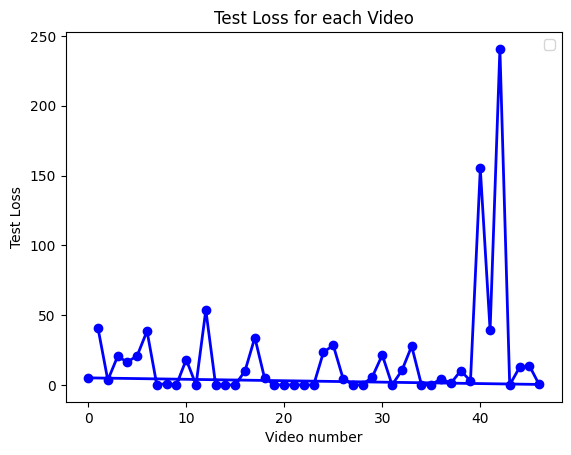

In [95]:
import matplotlib.pyplot as plt

a=[0]*len(tl)
for i in range(1,len(tl)):
    a[i-1]=i

plt.plot(a, tl, color='blue', marker='o', linestyle='-', linewidth=2)

plt.xlabel('Video number')
plt.ylabel('Test Loss')
plt.title('Test Loss for each Video')
plt.legend()
plt.show()

Making predictions

In [7]:
# import statements
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image

In [8]:
# preprocessing for the input images
def detect_black_border(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)[1]
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = sorted(contours, key=cv2.contourArea, reverse=True)[0]
    x, y, w, h = cv2.boundingRect(largest_contour)
    shrink_factor = 0.05
    x += int(w * shrink_factor)
    y += int(h * shrink_factor)
    w = int(w * (1 - 2 * shrink_factor))
    h = int(h * (1 - 2 * shrink_factor))
    return x, y, w, h

def img_preprocess(img_path, x, y, w, h, target_size=(224, 224)):
    image = cv2.imread(img_path)
    if x >= 0 and y >= 0 and w > 0 and h > 0:
        bbox = (x, y, x + w, y + h)
        cropped_image = Image.fromarray(image).crop(bbox)
        resized_image = cropped_image.resize(target_size, Image.BILINEAR)
    else:
        resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
    return img_to_array(resized_image)

In [9]:
# make predictions on the Train dataset by using the 20% of data which was kept aside during training.
def evaluate_model_on_test_videos(model, data_dir, video_folders_test):
    true_labels = []
    predicted_labels = []

    for video in video_folders_test:
        for sample in os.listdir(os.path.join(data_dir, video)):
            true_label = int(sample.split('_')[-1])  
            true_labels.append(true_label)

            temp = []
            for img_path in os.listdir(os.path.join(data_dir, video, sample)):
                img_path_full = os.path.join(data_dir, video, sample, img_path)
                x1, y1, w, h = detect_black_border(cv2.imread(img_path_full))
                processed_image = img_preprocess(img_path_full, x1, y1, w, h)
                temp.append(processed_image)

            test_data = np.expand_dims(np.array(temp), axis=0)
            predictions = model.predict(test_data)
            predicted_class = 0 if predictions[0][0] < 0.5 else 1
            predicted_labels.append(predicted_class)

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    return accuracy, precision, recall, f1, conf_matrix

def plot_loss(history):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    data_dir = "/kaggle/input/ps2-lc-pure/PS2Train"
    
    # the remaining 12 videos (20%) of dataset which was kept aside for testing and validation     
    video_test = ['video19', 'video03', 'video39', 'video20', 'video46', 'video10', 'video21', 'video18', 'video09', 'video56', 'video25', 'video15' ]
    model = load_model("/kaggle/input/final-model/final-backup-model.h5") 

    # Evaluate the model 
    accuracy, precision, recall, f1, conf_matrix = evaluate_model_on_test_videos(model, data_dir, video_test)

    # Evaluation metrics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("Confusion Matrix:")
    print(conf_matrix)



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


I0000 00:00:1713005585.559416      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━